In [68]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt

In [73]:
# 神目線
p_true_A = 0.05
p_true_B = 0.04

# 被験者数
N_A = 1500
N_B =  750

# 試験結果
# この結果から p_true を推定しようというもの
# 単に試験結果なので確率変数ではなく乱数でOK
occurences_A = pm.rbernoulli(p_true_A, N_A)
occurences_B = pm.rbernoulli(p_true_B, N_B)
# print(occurences_A)
# print(occurences_B)
# 単純頻度では真の確率とは違うよね
print("A:")
print("%d/%d=%03f" % (sum(occurences_A), N_A, sum(occurences_A)/N_A))
print("B:")
print("%d/%d=%03f" % (sum(occurences_B), N_B, sum(occurences_B)/N_B))

A:
73/1500=0.048667
B:
25/750=0.033333


In [74]:
# サイト A, B の実装がコンバージョンにつながったとする確率
# これを比較して AB テストを行いたい
# 理由不十分の原則より一様分布スタート
p_A = pm.Uniform("p_A", 0, 1)
p_B = pm.Uniform("p_B", 0, 1)

# 比較というのは rate = p_A-p_B のことだから
# それ自体を delta という確率変数にしてしまおう
@pm.deterministic
def delta(p_A=p_A, p_B=p_B):
    return p_A - p_B

In [75]:
# ベルヌーイ分布に従ったとする(TF分布だから妥当)
# 確率 p に従ったとする
# occurences という結果が出たとする(これを固定する)
obs_A = pm.Bernoulli("obs_A", p_A, value=occurences_A, observed=True)
obs_B = pm.Bernoulli("obs_B", p_B, value=occurences_B, observed=True)

# MCMC で p を推定しよう
# 関連する確率変数はすべて一つにまとめて MCMC
mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B])
mcmc.sample(25000, 5000)

 [-----------------100%-----------------] 25000 of 25000 complete in 4.6 sec

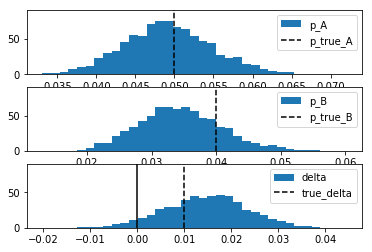

In [76]:
plt.subplot(3, 1, 1)
plt.vlines(p_true_A, 0, 90, linestyle="--", label="p_true_A")
plt.hist(mcmc.trace("p_A")[:], bins=35, normed=True, label="p_A")
# plt.xlim(0, 1)
plt.ylim(0, 90)
plt.legend()

plt.subplot(3, 1, 2)
plt.vlines(p_true_B, 0, 90, linestyle="--", label="p_true_B")
plt.hist(mcmc.trace("p_B")[:], bins=35, normed=True, label="p_B")
# plt.xlim(0, 1)
plt.ylim(0, 90)
plt.legend()

plt.subplot(3, 1, 3)
plt.vlines(0, 0, 90)
plt.vlines(p_true_A-p_true_B, 0, 90, linestyle="--", label="true_delta")
plt.hist(mcmc.trace("delta")[:], bins=35, normed=True, label="delta")
# plt.xlim(0, 1)
plt.ylim(0, 90)
plt.legend()

plt.show()

# delta のグラフの実践は「A も B も変わらない」確率なので，
# 分布の山が実践よりも正にふれていれば A の方が効果的であると判断できる

# (今回はそうでもないけど)基本的に推定結果の分布は
# データが少ない(=不確定度が高い)変数ほどすそ野が広がる
# (つまり今回は p_B の分布が広がっててほしかった)
# -> MCMC の結果から，「どのデータをもっと集めるべきか」も判断できる

In [78]:
# 数値で結果を見たければ delta が正であった頻度をみればいい
print("Probability site A is WORSE  than site B: %.3f" % (mcmc.trace("delta")[:] < 0).mean())
print("Probability site A is BETTER than site B: %.3f" % (mcmc.trace("delta")[:] > 0).mean())

Probability site A is WORSE  than site B: 0.048
Probability site A is BETTER than site B: 0.952
